# Overview

Here we are simply trying to minimize the root mean square error for predicting the 50th percentile [O/H] from SDSS spectroscopy. Everything in this notebook follows from the previous one.

# Imports and other necessary functions

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display


In [ ]:
PATH = os.path.abspath('..')

In [ ]:
def parse_csv_multi_class_probabilities(path_to_csv):
    """Parse filenames and probabilities for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of probabilities in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    probabilities = [probs for _, *probs in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, probabilities, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, probabilities, idx2class = parse_csv_multi_class_probabilities(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    prob_arr = np.array(probabilities).astype(np.float32)
    
    return full_names, prob_arr, idx2class

In [ ]:
@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

# Initialize network

Let's use the resnet50 this time. 
**Update:** 
- I've used a baatchsize of 2048, but the training stalls out at RMSE = 0.13
- batchsize of 512

In [5]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)

# test-val split
val_idxs = get_cv_idxs(n)

In [35]:
sz = 32
bs = 512
arch = resnet50

def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'images', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4, )

In [44]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data)

 15%|██████████▏                                                         | 179/1200 [00:20<01:54,  8.95it/s, loss=0.25]

In [37]:
def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse

 81%|████████████████████████████████████████████████████████▏            | 977/1200 [00:45<00:10, 21.29it/s, loss=1.7]

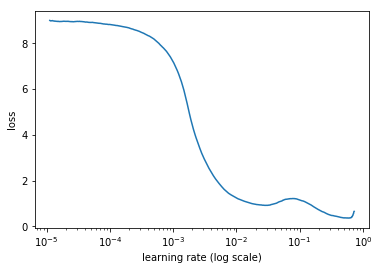

 81%|████████████████████████████████████████████████████████▏            | 977/1200 [01:00<00:13, 16.28it/s, loss=1.7]

In [38]:
learn.lr_find()
learn.sched.plot()

# Begin training

## Initial training of activations

I remember from before that a learning rate of 0.1 seems good...

In [46]:
lr = 0.1
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss                                                                                         
    0      0.104786   0.098066  
    1      0.103985   0.096583                                                                                         
    2      0.099725   0.0946                                                                                           


[array([0.0946])]

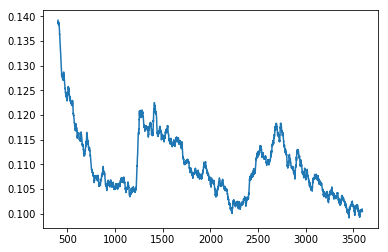

In [47]:
learn.sched.plot_loss(n_skip=400)

In [48]:
lr = 1e-3
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.102818   0.09484   
    1      0.101749   0.095435                                                                                         
    2      0.100543   0.095067                                                                                         
    3      0.101057   0.094376                                                                                         
    4      0.098713   0.094268                                                                                         
    5      0.099332   0.094401                                                                                         
    6      0.101585   0.094455                                                                                         


[array([0.09446])]

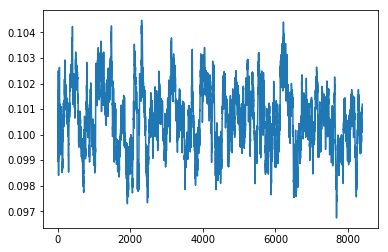

In [49]:
learn.sched.plot_loss()

In [50]:
learn.save('resnet50_32_init')
#learn.load('resnet50_32_init')

## (optional) Specifying training phases
See the notebook by [Sylvain Gugger](https://github.com/fastai/fastai/blob/master/courses/dl2/training_phase.ipynb)

In [42]:
lr = 1e-2
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr=(lr/10, lr), lr_decay=DecayType.LINEAR, 
                          momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=1, opt_fn=optim.SGD, lr=(lr, lr/10), lr_decay=DecayType.LINEAR, 
                          momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=1, opt_fn=optim.Adam, lr=lr/10, lr_decay=DecayType.COSINE, momentum=0.9)]

In [43]:
learn.fit_opt_sched(phases)

epoch      trn_loss   val_loss                                                                                         
    0      0.245331   0.245252  
 15%|██████████▏                                                         | 179/1200 [00:08<00:49, 20.75it/s, loss=0.25]

KeyboardInterrupt: 

In [ ]:
learn.sched.plot_lr(show_moms=False)

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('resnet50_32_custom-training-phases')
#learn.load('resnet50_32_custom-training-phases')

## Unfreeze early layers
We'll also lower the training rate slightly

In [51]:
learn.unfreeze()
lrs = 3e-2 * np.array([1/9, 1/3, 1])

learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.090103   0.083996  
    1      0.080852   0.075051                                                                                         
    2      0.080026   0.074237                                                                                         
    3      0.076745   0.072233                                                                                         
    4      0.077078   0.071029                                                                                         
    5      0.07821    0.070176                                                                                         
    6      0.073495   0.069983                                                                                         


[array([0.06998])]

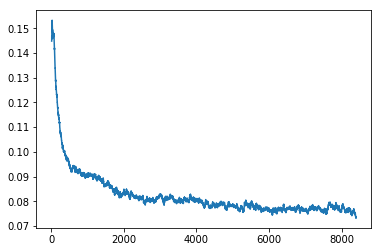

In [52]:
learn.sched.plot_loss()

In [53]:
learn.save('resnet50_32_diff-1')
#learn.load('resnet50_32_diff-1')

## Size up to 64x64 
Let's re-freeze + train some

epoch      trn_loss   val_loss                                                                                         
    0      0.104491   0.096288  
    1      0.101942   0.092178                                                                                         
    2      0.0987     0.089534                                                                                         


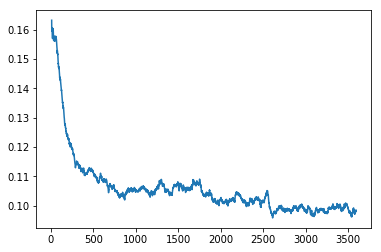

In [54]:
data = get_data(64, 128)
learn.set_data(data)

learn.freeze()

lr = 3e-2
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                                                                                         
    0      0.097395   0.088832  
    1      0.096812   0.088086                                                                                         
    2      0.097964   0.088482                                                                                         


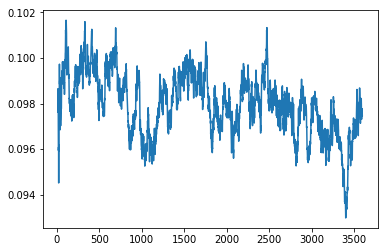

In [55]:
lr = 1e-2

learn.fit(lr, 2, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

In [56]:
learn.save('resnet50_32-64_init')

Unfreeze and train more

epoch      trn_loss   val_loss                                                                                         
    0      0.078016   0.071397  
    1      0.072891   0.067005                                                                                         
    2      0.071373   0.067303                                                                                         
    3      0.073405   0.066652                                                                                         
    4      0.06948    0.065494                                                                                         
    5      0.070184   0.063264                                                                                         
    6      0.069299   0.063426                                                                                         


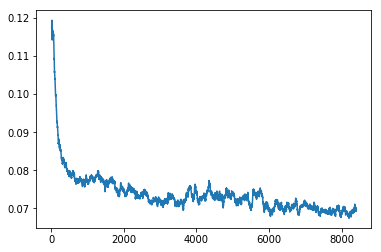

In [57]:
learn.unfreeze()

lrs = 1e-2 * np.array([1/9, 1/3, 1])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [58]:
learn.save('resnet50_32-64_diff-1')
#learn.load('resnet50_32-64_diff-1')

epoch      trn_loss   val_loss                                                                                         
    0      0.067285   0.06388   
    1      0.068587   0.064568                                                                                         
    2      0.068439   0.063007                                                                                         
    3      0.069183   0.063769                                                                                         
    4      0.068967   0.062811                                                                                         
    5      0.069427   0.062713                                                                                         
    6      0.069942   0.062856                                                                                         


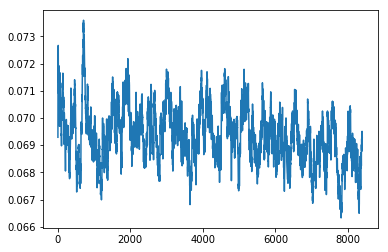

In [59]:
lrs = 3e-3 * np.array([1/16, 1/4, 1])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [60]:
learn.save('resnet50_32-64_diff-2')
#learn.load('resnet50_32-64_diff-2')

In [61]:
lrs = 1e-3 * np.array([1/16, 1/4, 1])
learn.fit(lrs, n_cycle=5, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.067785   0.063404  
    1      0.067573   0.062992                                                                                         
    2      0.068799   0.0627                                                                                           
    3      0.068483   0.062701                                                                                         
    4      0.068435   0.063015                                                                                         
    5      0.068763   0.063302                                                                                         
    6      0.068381   0.063262                                                                                         
    7      0.068141   0.063359                                                                                         
    8  

[array([0.0618])]